## From Theory to Practice

Let's step through some parts of scikit-learn an highlight the correspondence between the conceptual foundations above and their counterparts in the library.


## Big Picture...

...it is a process.

<a href="https://ohi-science.org/data-science-training/img/r4ds_data-science.png">
<img src="https://ohi-science.org/data-science-training/img/r4ds_data-science.png" alt="Data Science Workflow by Hadley Wickham" width=800>
</a>

## Example Data

We will use a synthetic data set.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_decision_regions
%matplotlib inline


def load_data():
    return make_moons(n_samples=200, noise=0.3, random_state=123, )


def visualize_data(X, y):
    fig, ax = plt.subplots()
    ax.scatter(*X.T, c=y)
    return fig, ax

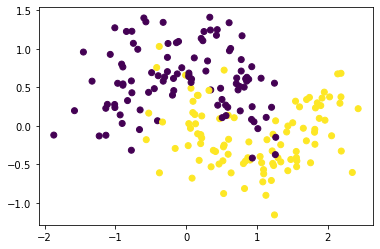

In [6]:
X, y = load_data()
fig, ax = visualize_data(X, y)

## Explore Data

*For this summary, we skip this part.*

## Training and Test Sets

Before we train above model, we split the data into *train* and *test* set to able to evaluate the models generalization performance.

It is common to reserve 20% to 30% of the data for test purposes.

---

*There may be reasons for a different choice but here we go with above split.*

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42)

## Chosing a Model

> How are we going to approximate $f$?

### Different Options...

<a href="https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">
<img src="../images/sklearn/ml_map.png" alt="Chosing the right estimator" width=800>
</a>

*No free lunch*; finding the appropriate model is part of the analysis.

### Scikit-Learn

As a start:
- [User guide](https://scikit-learn.org/stable/user_guide.html)
- [Tutorial](https://scikit-learn.org/stable/tutorial/index.html)
- [API documentation](https://scikit-learn.org/stable/modules/classes.html)

Most models accept a range of parameters, often referred to as *hyperparameters*, that specify the behavior of the model.

### Model Selection: Optimizing Parameters by Performing a Search
### Model Training: Estimating $\hat{f}$

For now: 
[Decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

It takes parameters such as
- `max_depth` (the maximum depth of the tree)
- `min_samples_split` (minimum number of samples required to split a node) which allow the user to tune its flexibility


Without the need to know anything about a model's internals, we can
- use CV to chose hyperparameters and
- `fit()` to obtain an approximation $\hat{f}$

of the underlying generating mechanism $f$.

In [8]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier

DecisionTreeClassifier()

[`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), offers a range of tools for model selection purposes.

A simple way to *cross-validate* a set of parameters is to perform a *grid search* where an exhaustive search over specific parameter values is performed.

In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [10, 7, 5, 3, 2, 1], 
              'min_samples_split': [2, 5, 10, 15, 20]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), 
                              param_grid, 
                              cv=10,  # performs train-test-splits for us
                              return_train_score=True, 
                              n_jobs=3)
grid_search_cv.fit(X, y)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=3,
             param_grid={'max_depth': [10, 7, 5, 3, 2, 1],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             return_train_score=True)

In [10]:
# what is the best parameter combination?
print('best_score', grid_search_cv.best_score_)
print('best_params', grid_search_cv.best_params_)

best_score 0.9
best_params {'max_depth': 10, 'min_samples_split': 15}


In [11]:
model_according_to_cv_for_final_evaluation = grid_search_cv.best_estimator_
model_according_to_cv_for_final_evaluation
# fit the model on the train and evaluate on the test set
model_according_to_cv_for_final_evaluation.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=15)

### Making a Prediction

Once the model is fitted, we obtain $\hat{f}(x)$ by calling `model.predict(X)` on the model.

In [12]:
# let's compute predictions for both the training and the test set
y_train_pred = model_according_to_cv_for_final_evaluation.predict(X_train)
y_test_pred = model_according_to_cv_for_final_evaluation.predict(X_test)

### Assessing Model Accuracy

A wide range of different metrics are available in [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics) module.

For our classification problem, *precision* and *recall* are useful metrics.

<a href="https://en.wikipedia.org/wiki/Precision_and_recall">
<img src="../images/wiki/Precisionrecall.svg.png" alt="Chosing the right estimator" width="300">
</a>

In [13]:
from sklearn.metrics import classification_report

print('Performance on training set:')
print(classification_report(y_train, y_train_pred))
print('---')
print('Performance on test set:')
print(classification_report(y_test, y_test_pred))

Performance on training set:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        64
           1       0.97      0.92      0.95        76

    accuracy                           0.94       140
   macro avg       0.94      0.94      0.94       140
weighted avg       0.94      0.94      0.94       140

---
Performance on test set:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        36
           1       0.85      0.92      0.88        24

    accuracy                           0.90        60
   macro avg       0.89      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



In [14]:
from sklearn.metrics import confusion_matrix

print('Performance on training set summarized as confusion matrix:')
print(confusion_matrix(y_train, y_train_pred))
print('---')
print('Performance on test set summarized as confusion matrix:')
print(confusion_matrix(y_test, y_test_pred))

Performance on training set summarized as confusion matrix:
[[62  2]
 [ 6 70]]
---
Performance on test set summarized as confusion matrix:
[[32  4]
 [ 2 22]]


### Going into production

Fit model on entire data set, i.e. use all information available.

In [16]:
model_according_to_cv_for_use_in_production = grid_search_cv.best_estimator_
model_according_to_cv_for_use_in_production.fit(X, y)

DecisionTreeClassifier(max_depth=10, min_samples_split=15)

In [18]:
# model.predict(X_unseen)

# Once you have a base line...

... try another model

---

*Naturally, the model choice itself is a hyperparameter and can be treated this way.
However, in this class, for sake of simplicity we do not automate this aspect.*